In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import collections
import einops
import matplotlib.pyplot as plt
import math
import numpy as np
import torch as t
from torch import nn
import transformers
from IPython.core.display import HTML, display

import minigpt_utils
from days.utils import *


tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"

In [ ]:
gen_model = transformers.GPT2LMHeadModel.from_pretrained("gpt2")

In [4]:
eval_model = minigpt_utils.get_minigpt("model.pt")

### VWAS for minigpt

Let's see if VWAS correspond to our intuitive understanding of what should activate the heads.

`value-weighted attention scores (from, to) = score(from,to)*norm(V(from))`

In [55]:
texts = [
    "[BEGIN] Now that we've tried a one-layer model, let's try a two-layer model.",
    "[BEGIN] Now that we've tried a one-layer model, let's try a two layer model.",
    "[BEGIN] Now that we've tried a one-layer model, let's try something else.",
]

In [56]:
input_ids = tokenizer(texts, return_tensors='pt', padding=True).input_ids

In [57]:
eval_model(input_ids).shape

torch.Size([3, 21, 50259])

In [58]:
weighted_attns = eval_model.weighted_attention(input_ids)
# -> [n_layer, n_batch, n_head, q, k]
weighted_attns.shape

torch.Size([2, 3, 8, 21, 21])

In [59]:
vwas_1_4 = weighted_attns[1,:,4,:,:]
vwas_1_5 = weighted_attns[1,:,5,:,:]
vwas_1_6 = weighted_attns[1,:,6,:,:]

In [60]:
vwas_1_4.shape

torch.Size([3, 21, 21])

In [61]:
print(t.sum(vwas_1_4, dim=[-1,-2]),
      t.sum(vwas_1_5, dim=[-1,-2]),
      t.sum(vwas_1_6, dim=[-1,-2]))

tensor([7.9436, 6.6319, 6.1856]) tensor([52.7071, 52.9230, 51.7804]) tensor([22.2051, 21.7206, 20.3310])


In [62]:
print(t.max(t.max(vwas_1_4, dim=-1).values, dim=-1).values,
      t.max(t.max(vwas_1_5, dim=-1).values, dim=-1).values,
      t.max(t.max(vwas_1_6, dim=-1).values, dim=-1).values)

tensor([1.3423, 0.6032, 0.2870]) tensor([1.7162, 1.7162, 1.7162]) tensor([1.2685, 0.6566, 0.6566])


In [66]:
input_ids[:,15:]
# 1st sentence: ( a, one), ( -,layer), (layer, model), ( model,,)
#                15,  7     17,   9        18,  10         19, 11
# 2nd sentence: ( a, one), ( model,,)
#               15,   7        18,11
# 3rd sentence: 

tensor([[  257,   734,    12, 29289,  2746,    13],
        [  257,   734,  7679,  2746,    13, 50258],
        [ 1223,  2073,    13, 50258, 50258, 50258]])

In [67]:
input_ids

tensor([[50257,  3844,   326,   356,  1053,  3088,   257,   530,    12, 29289,
          2746,    11,  1309,   338,  1949,   257,   734,    12, 29289,  2746,
            13],
        [50257,  3844,   326,   356,  1053,  3088,   257,   530,    12, 29289,
          2746,    11,  1309,   338,  1949,   257,   734,  7679,  2746,    13,
         50258],
        [50257,  3844,   326,   356,  1053,  3088,   257,   530,    12, 29289,
          2746,    11,  1309,   338,  1949,  1223,  2073,    13, 50258, 50258,
         50258]])

In [68]:
def get_token_idx(word, tokenizer, inputs):
    tokenized_word = tokenizer(word).input_ids
    assert len(tokenized_word) == 1, tokenized_word
    token = tokenized_word[0]
    idxs = (inputs == token).nonzero()
    return idxs
get_token_idx(",", tokenizer, input_ids)

tensor([[ 0, 11],
        [ 1, 11],
        [ 2, 11]])

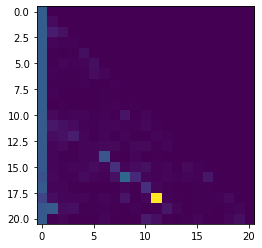

In [69]:
plt.imshow(vwas_1_4[1])

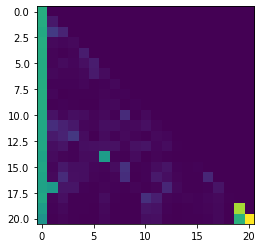

In [70]:
plt.imshow(vwas_1_4[2])

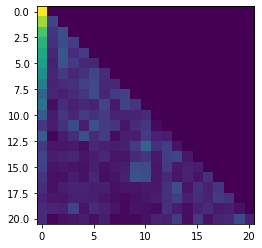

In [71]:
plt.imshow(vwas_1_5[1])

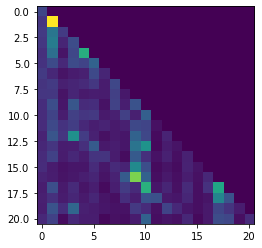

In [72]:
plt.imshow(vwas_1_6[1])

In [78]:
t.sum(vwas_1_4).item()

20.76110076904297

In [79]:
t.save(eval_model, )

TypeError: save() missing 1 required positional argument: 'f'

### VO for all tokens

In [5]:
input_ids = t.arange(50259).unsqueeze(0)
input = eval_model.token_embedding(input_ids)

In [27]:
layer = eval_model.blocks[1]

In [28]:
_, _, v = t.split(layer.project_qkv(input), layer.hidden_size, dim=-1)
v = einops.rearrange(v, 'b n (h l) -> b h n l', l=layer.head_size)
o_heads = einops.rearrange(layer.project_output.weight, '(h1 l1) (h2 l2) -> h1 l1 h2 l2', h1 = layer.n_heads, h2 = layer.n_heads)
ov = t.einsum('imhl,bhnl -> binm', o_heads, v)
normed_ov = t.norm(ov, dim=-1)

In [25]:
ov_norms = {}
ov_norms[0] = {}
for h in range(8):
    ov_norms[0][h] = {}
    for token in range(50259):
        ov_norms[0][h][token] = normed_ov[0, h, token].item()

In [31]:
ov_norms[1] = {}
for h in range(8):
    ov_norms[1][h] = {}
    for token in range(50259):
        ov_norms[1][h][token] = normed_ov[0, h, token].item()

In [32]:
import json
with open('ov_norms_jan5_model.json', 'w') as f:
    json.dump(ov_norms, f)

In [90]:
[sum(np.array(list(ov_norms[l][h].values())) > 11) for l in range(2) for h in range(8)]

[339, 2, 12, 8, 187, 4904, 1288, 1, 367, 562, 144, 407, 372, 546, 192, 573]

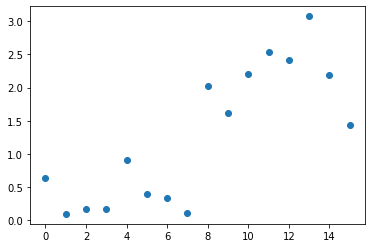

In [102]:
plt.scatter(range(16), [ov_norms[l][h][50257] for l in range(2) for h in range(8)]);

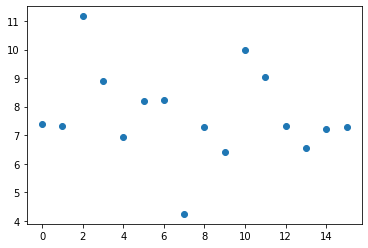

In [96]:
plt.scatter(range(16), [ov_norms[l][h][4222] for l in range(2) for h in range(8)]);

In [92]:
tokenizer.decode(np.argpartition(list(ov_norms[0][2].values()), -12)[-12:])

' presupp caric prophe precip Please kindredJoinIntrodu Nevertheless Emails CONTIN subscribing'

In [93]:
tokenizer.decode(np.argpartition(list(ov_norms[1][2].values()), -144)[-144:])

' exclus tox inn wom promotions Gret NXT Vietnamese Bent Univers Neander Kushner Witt Bavcru jungSubscribe tsun dys Kimmel Oops Vietannabin massage Italians Hondlopp Sioux CONTIN Scarborough Aeaqu ambul vapctory Stur precip BeastsRom LR Swed bona HurricanesIv Immun Travels Comet aeros WemAUT Turk SchlMer MaduroINGTON Hannibal Nun DDR van Barr lav Gly Resp Indo Okinawa respiribli calves leth dign POW HelmRow diarr tides SiegMcC Benz hyd ALP schizophrenia san kindred reun fet cruiser Thank Manit Franç haz psychiatric Okin tidal partic roundup Emails Ivanka Pug USS WW microbi frigIntrodu Geh McCull sequJenn euth soap Sha preeDamn Valkyrie Kislyak ove cum maternity Bie Cowboys -------------------- PLA allergic Manafort tranqu Strait KluVERTIS Esk Kers hepatitis liqu skirm Falk typh polyg Barton bron Latter subscribing Melaniayoutu Sixers claNAT'

In [76]:
sort_ov = [sorted(ov_norms[l][h].values()) for l in range(2) for h in range(8)]

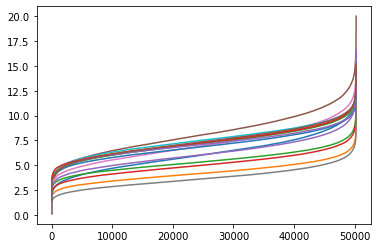

In [85]:
[plt.plot(sorted(ov_norms[l][h].values())) for l in range(2) for h in range(8)];

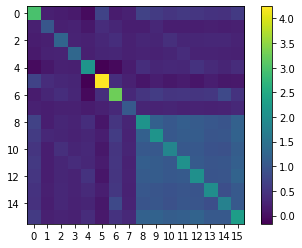

In [101]:
plt.imshow(np.cov([list(ov_norms[l][h].values()) for l in range(2) for h in range(8)]))
plt.colorbar()
plt.xticks(range(16));